In [1]:
from common_imports import *
from utils.labeling import *
from utils.candlestick_img import *

c:\Users\user\anaconda3\envs\2024_stock_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
def generate_technical_analysis_indicators(df):
    # 볼린저 밴드
    df['BBAND_UPPER'],df['BBAND_MIDDLE'],df['BBAND_LOWER'] = talib.BBANDS(df['close'], 20, 2)
    
    # 모멘텀
    df['MOM'] = talib.MOM(df["close"], timeperiod=10)
    
    # DMI
    df['DMI'] = talib.DX(df["high"], df["low"], df["close"], timeperiod=14)
    
    # ROC
    df['ROC'] = talib.ROC(df["close"], timeperiod=10)
    
    # ADX
    df['ADX'] = talib.ADX(df["high"], df["low"], df["close"], timeperiod=14)
    
    # AROON Oscillator
    df['AROON_OSC'] = talib.AROONOSC(df["high"], df["low"], timeperiod=14)
    
    # CCI
    df['CCI'] = talib.CCI(df["high"], df["low"], df["close"], timeperiod=9)
    
    # RSI (원래는 14가 기본값으로 제공되지만 우리는 12로 사용함)
    df['RSI'] = talib.RSI(df["close"], timeperiod=10)
    
    # Stochastic
    df['slowk'], df['slowd'] = talib.STOCH(df["high"], df["low"], df["close"], fastk_period=12, slowk_period=5, slowk_matype=0, slowd_period=5, slowd_matype=0)
    df['fastk'], df['fastd'] = talib.STOCHF(df["high"], df["low"], df["close"], fastk_period=12, fastd_period=5, fastd_matype=0)
    
    # Chande Momentum Oscilator
    df['CMO'] = talib.CMO(df["close"], timeperiod=9)
    
    # Percentage Price Oscillator
    df['PPO'] = talib.PPO(df["close"], fastperiod=10, slowperiod=20, matype=0)
    
    # Ultimate Oscillator
    df['UO'] = talib.ULTOSC(df["high"], df["low"], df["close"], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    
    df['BOP'] = talib.BOP(df['open'], df['high'], df['low'], df['close'])
    
    # MA ------------------
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['EMA_120'] = df['close'].ewm(span=120, adjust=False).mean()
    df['EMA_200'] = df['close'].ewm(span=200, adjust=False).mean()    
    
    return df

In [77]:
import FinanceDataReader as fdr

In [181]:
df = fdr.DataReader('KS11', '2022-02-10', '2024-12-31')
df = df.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'})

1 001 2022-02-10 00:00:00 2024-02-09 00:00:00
1 001 2024-02-10 00:00:00 2026-02-09 00:00:00


In [110]:
df = generate_technical_analysis_indicators(df)

In [227]:
from common_imports import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_candles(pricing, title=None, trend_line=False, volume_bars=False, color_function=None, technicals=None):
    def default_color(index, open_price, close_price, low, high):
        return 'b' if open_price[index] > close_price[index] else 'r'
    
    color_function = color_function or default_color
    technicals = technicals or []
    open_price = pricing['open']
    close_price = pricing['close']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    def plot_trendline(ax, pricing, linewidth=5):
        x = np.arange(len(pricing))
        y = pricing.values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), 'g--', linewidth=2)
        mean_price = np.mean(y)
        std_price = np.std(y)
        ax.plot(x, [mean_price + std_price] * len(x), 'k--', linewidth=2)
        ax.plot(x, [mean_price - std_price] * len(x), 'k--', linewidth=2)
    
    if volume_bars:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,10))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(30,12))
    
    # 배경을 투명하게 설정
    fig.patch.set_alpha(0.0)
    ax1.patch.set_alpha(0.0)
    if volume_bars:
        ax2.patch.set_alpha(0.0)
    
    if title:
        ax1.set_title(title)
    fig.tight_layout()
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x, low, high, color=candle_colors, linewidth=1)
    
    if trend_line:
        plot_trendline(ax1, pricing['close'])
    
    # X축에 날짜 표시
    dates = pricing['date']  # 데이터프레임의 'date' 컬럼 사용
    ax1.set_xticks(x[::max(1, len(pricing)//10)])  # 10개 간격으로 틱 설정 (데이터 길이에 따라 조정)
    ax1.set_xticklabels(dates[::max(1, len(pricing)//10)])  # 날짜 레이블 회전 및 정렬
    
    ax1.xaxis.grid(True)
    ax1.yaxis.grid(True)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    
    # 볼린저 밴드 색상 지정
    for indicator in technicals:
        if indicator.name in ['BBAND_UPPER', 'BBAND_LOWER']:
            ax1.plot(x, indicator, label=indicator.name, color='#0000FF', linewidth=2.0, alpha=1.0)
        elif indicator.name in ['BBAND_MIDDLE']:
            ax1.plot(x, indicator, label=indicator.name, color="#1BBD36", linewidth=2.0, alpha=1.0)
        else:
            ax1.plot(x, indicator, linewidth=1.5)
    
    if volume_bars:
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'volume'
        if volume_scale:
            volume_title = 'volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        # 볼륨 차트에도 동일한 X축 날짜 표시
        ax2.set_xticks(x[::max(1, len(pricing)//10)])
        ax2.set_xticklabels(dates[::max(1, len(pricing)//10)], rotation=45, ha='right')
        ax2.xaxis.grid(True)
    
    plt.tight_layout()  # 레이아웃 조정
    return fig

In [228]:
df = pd.read_csv("./data/origin_data/origin_data.csv")
df

,time,open,high,low,close,volume
0,2022-02-10 09:00:00,370.70,371.90,370.70,371.55,7202
1,2022-02-10 09:01:00,371.55,371.85,371.35,371.80,3007
2,2022-02-10 09:02:00,371.80,372.10,371.45,371.65,3332
3,2022-02-10 09:03:00,371.65,371.80,371.50,371.65,1575
4,2022-02-10 09:04:00,371.65,371.70,371.30,371.45,1585
...,...,...,...,...,...,...
285212,2024-12-30 15:31:00,319.20,319.35,319.15,319.25,768
285213,2024-12-30 15:32:00,319.25,319.30,319.15,319.15,433
285214,2024-12-30 15:33:00,319.15,319.20,319.05,319.10,539
285215,2024-12-30 15:34:00,319.10,319.10,318.75,318.85,1075


In [229]:
# 'time' 컬럼을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

# 날짜만 추출하여 새로운 'date' 컬럼 생성
df['date'] = df['time'].dt.date

In [230]:
daily_df = df.groupby('date').agg({
    'open': 'first',          # 첫 번째 open 값
    'high': 'max',           # 최대 high 값
    'low': 'min',            # 최소 low 값
    'close': 'last',         # 마지막 close 값
    'volume': 'sum'
}).reset_index()


In [231]:
df = generate_technical_analysis_indicators(daily_df)

In [232]:
df

,date,open,high,low,close,volume,BBAND_UPPER,BBAND_MIDDLE,BBAND_LOWER,MOM,...,slowd,fastk,fastd,CMO,PPO,UO,BOP,EMA_50,EMA_120,EMA_200
0,2022-02-10,370.70,372.45,369.00,371.75,298161,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.304348,371.750000,371.750000,371.750000
1,2022-02-11,368.45,370.80,366.30,368.00,288488,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.100000,371.602941,371.688017,371.712687
2,2022-02-14,365.00,365.95,360.30,363.65,300081,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.238938,371.291061,371.555157,371.632461
3,2022-02-15,363.90,364.70,358.90,360.55,278627,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.577586,370.869843,371.373253,371.522188
4,2022-02-16,364.85,367.65,364.50,367.35,214474,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.793651,370.731810,371.306753,371.480673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2024-12-23,320.40,323.80,318.75,322.60,208949,336.440138,326.0375,315.634862,8.50,...,62.439809,45.219638,49.560724,-9.153269,-0.319748,45.881185,0.435644,333.067485,344.649255,348.643619
704,2024-12-24,322.60,324.40,321.40,323.15,131106,334.823534,325.4000,315.976466,2.30,...,58.586758,48.062016,47.286822,-7.273573,-0.053780,45.780058,0.183333,332.678564,344.293896,348.389951
705,2024-12-26,324.80,325.15,320.65,321.10,149054,333.602777,324.7800,315.957223,-2.95,...,51.457282,34.417344,37.942900,-13.518370,0.046185,46.244336,-0.822222,332.224503,343.910525,348.118409
706,2024-12-27,321.25,321.90,317.40,319.55,190584,332.650146,324.1675,315.684854,-10.25,...,45.044684,26.016260,35.135816,-18.204094,-0.080977,47.918662,-0.377778,331.727464,343.507872,347.834146


In [234]:
# 폰트 크기 설정 (전역적으로 적용)
plt.rcParams.update({
    'axes.titlesize': 40,    # 제목 폰트 크기
    'axes.labelsize': 30,    # Y축 레이블 폰트 크기 (metric 강조)
    'xtick.labelsize': 25,   # X축 눈금 레이블 폰트 크기
    'ytick.labelsize': 20,   # Y축 눈금 레이블 폰트 크기
    'legend.fontsize': 20    # 범례 폰트 크기
})

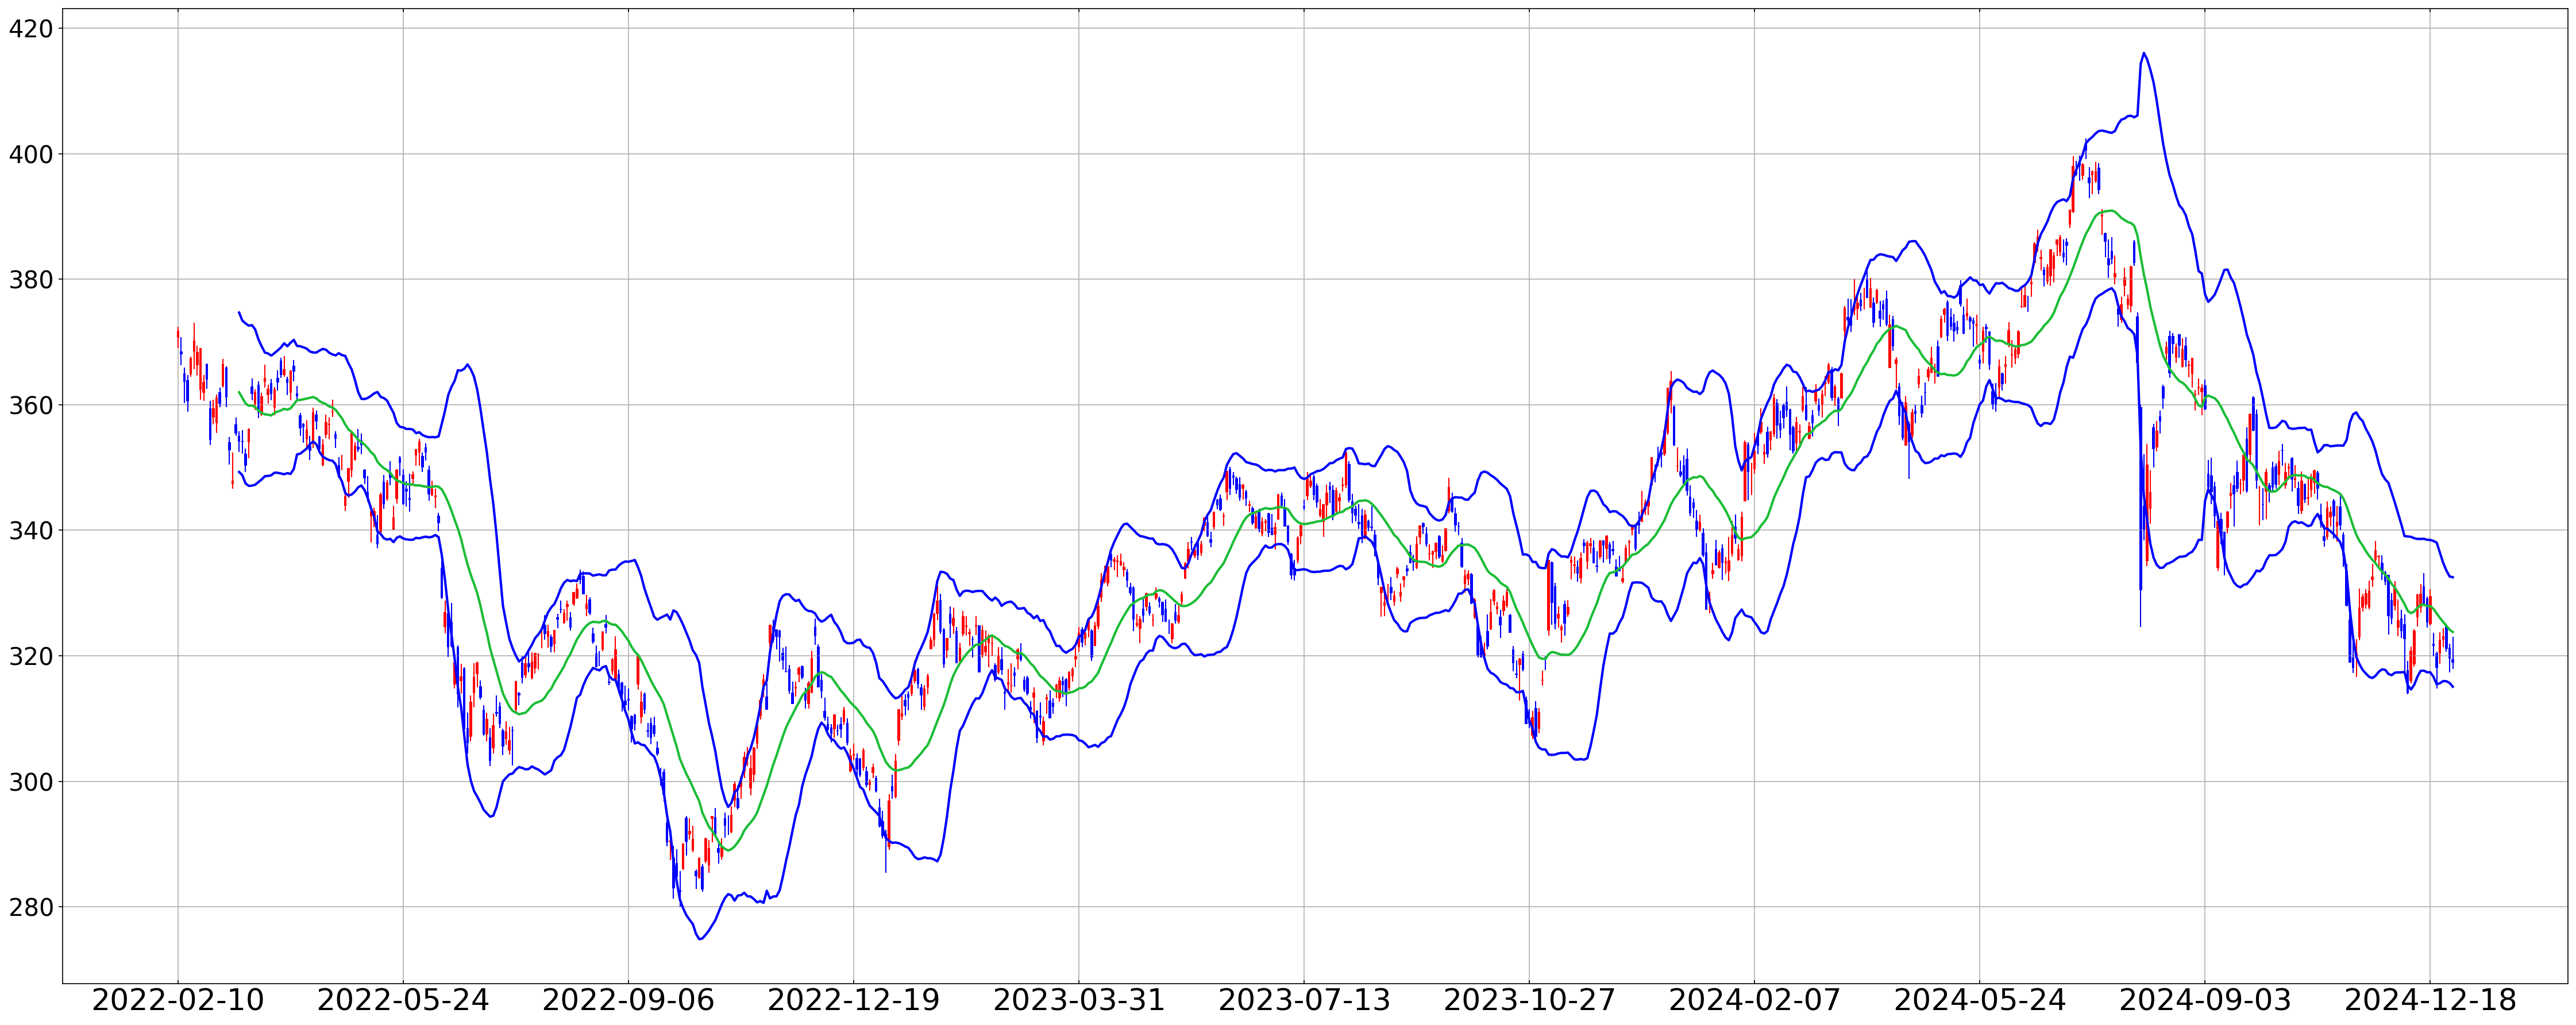

In [235]:
fig = plot_candles(df, title=None, trend_line=False, volume_bars=False, color_function=None, technicals=[df['BBAND_UPPER'], df['BBAND_MIDDLE'], df['BBAND_LOWER']])

In [70]:
# 폰트 크기 설정 (전역적으로 적용)
plt.rcParams.update({
    'axes.titlesize': 40,    # 제목 폰트 크기
    'axes.labelsize': 30,    # Y축 레이블 폰트 크기 (metric 강조)
    'xtick.labelsize': 25,   # X축 눈금 레이블 폰트 크기
    'ytick.labelsize': 20,   # Y축 눈금 레이블 폰트 크기
    'legend.fontsize': 20    # 범례 폰트 크기
})

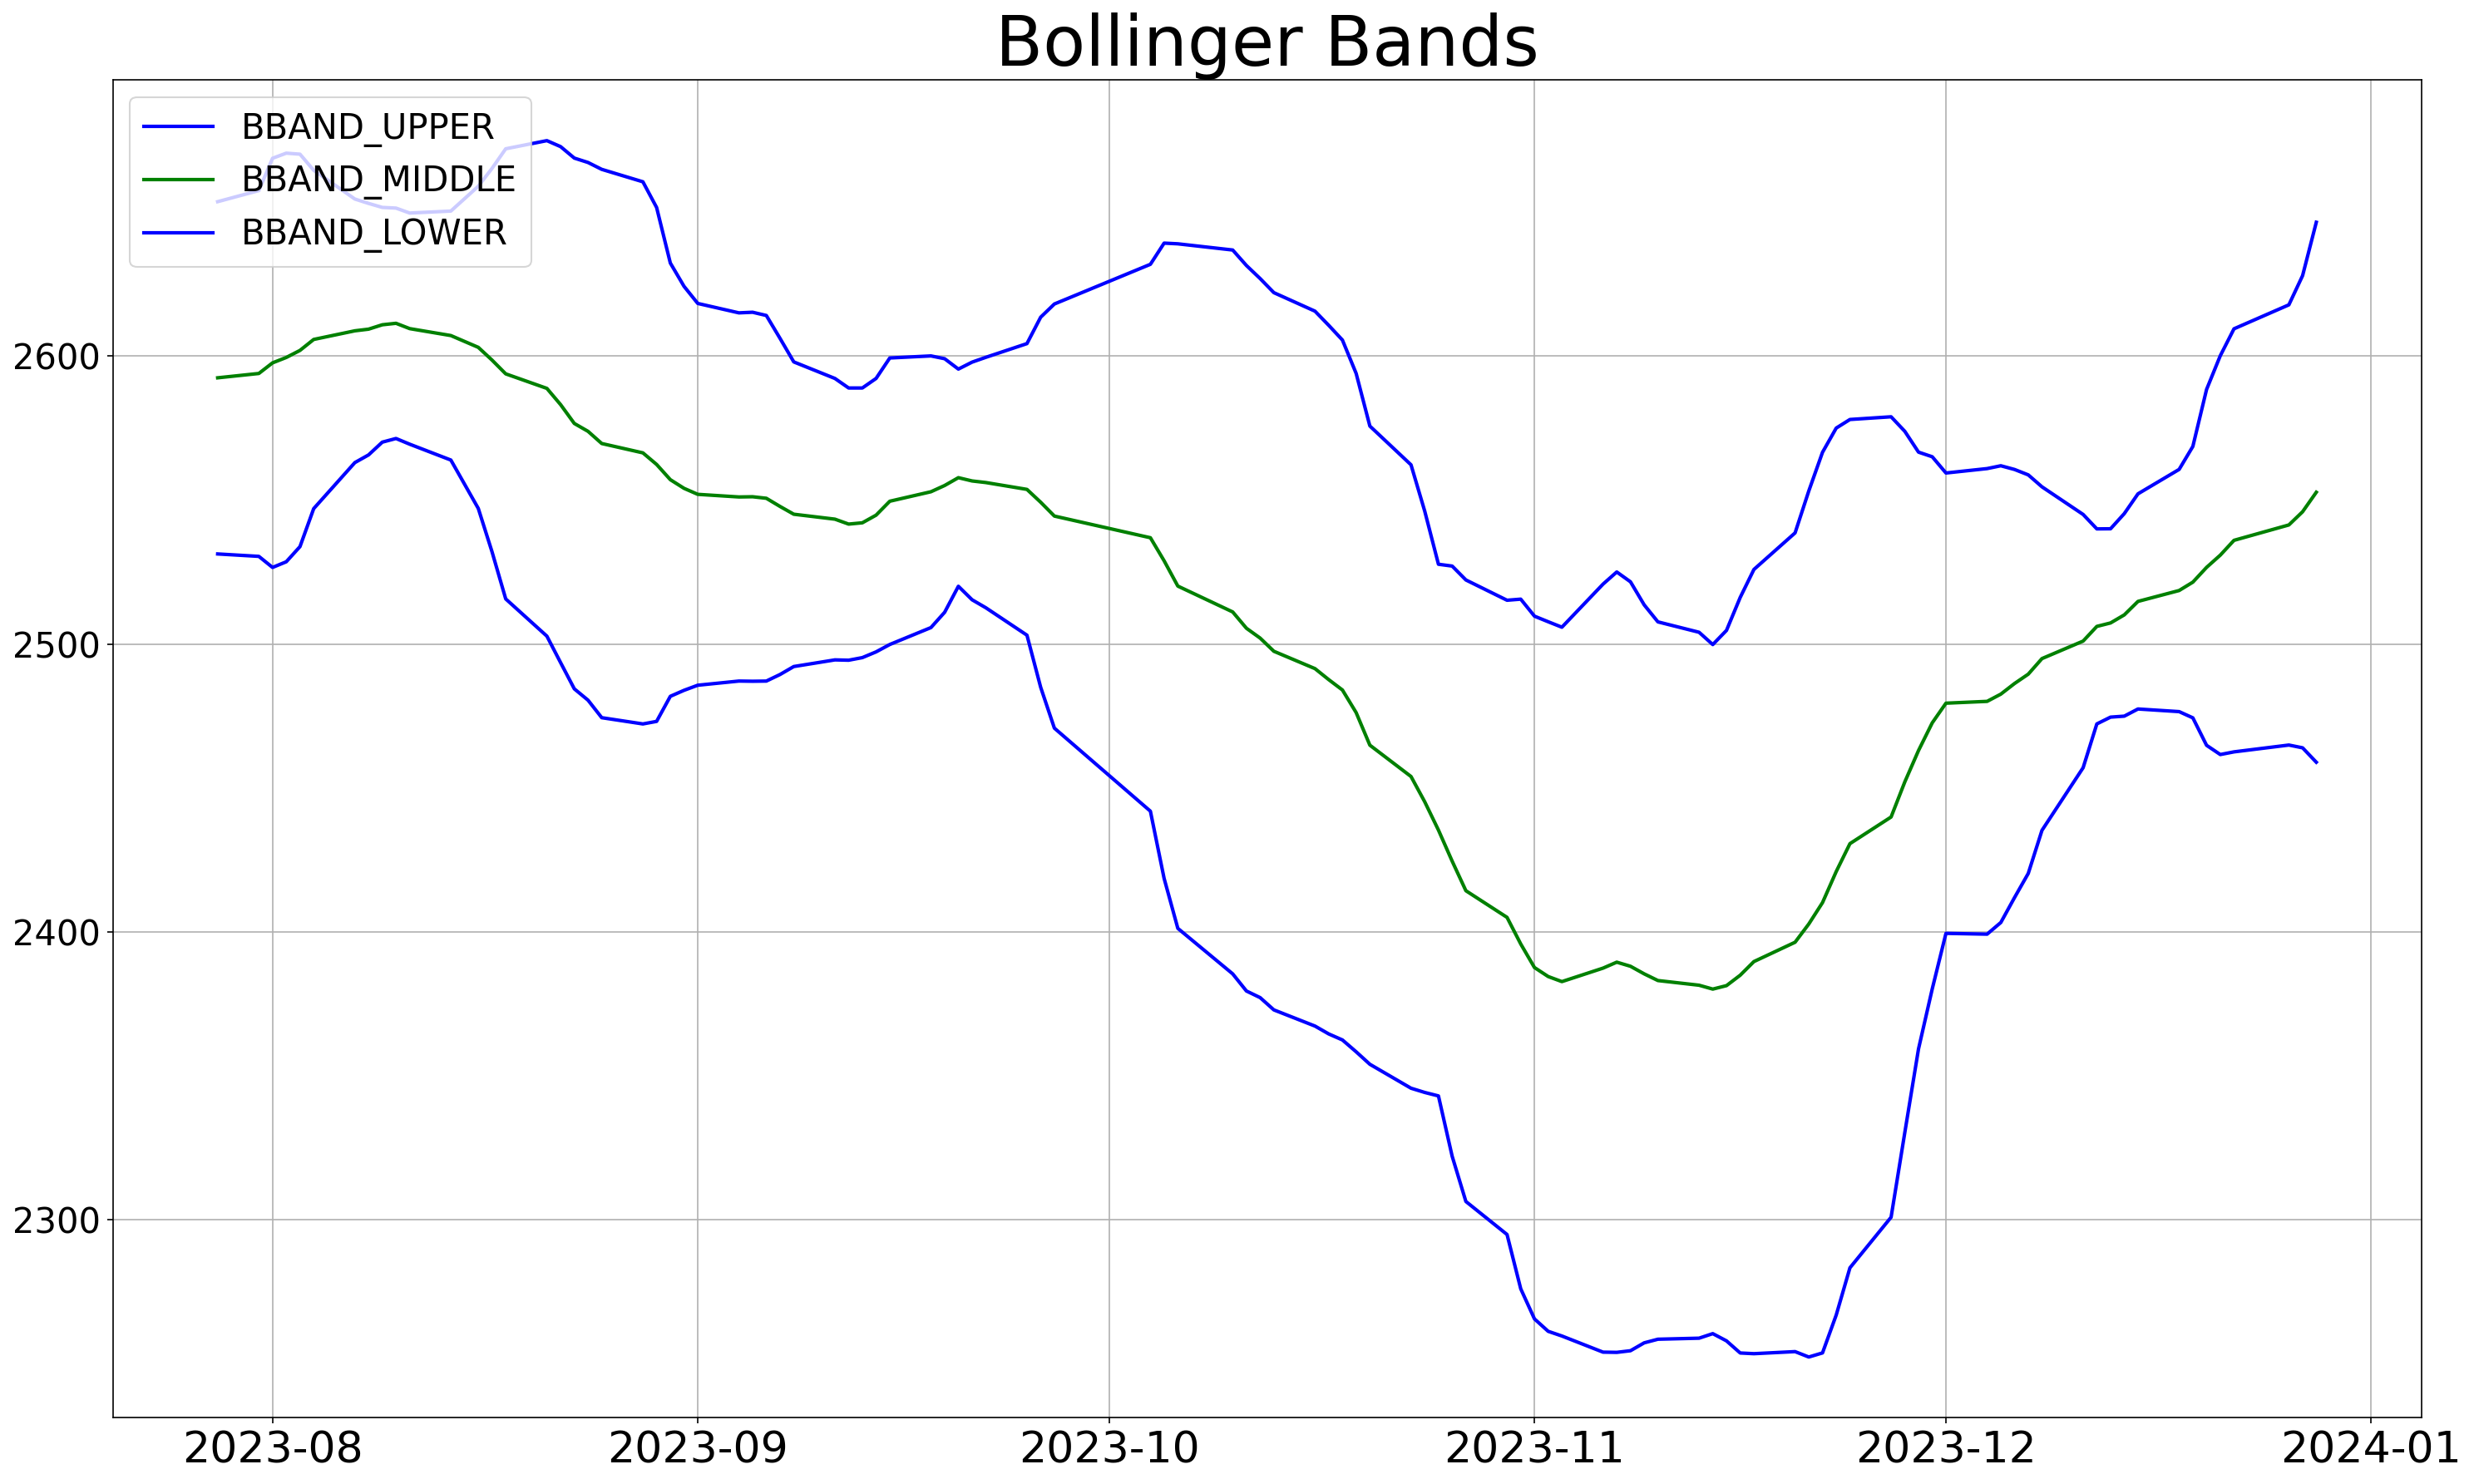

In [74]:
import matplotlib.pyplot as plt

# 데이터프레임의 BBAND_UPPER, BBAND_MIDDLE, BBAND_LOWER 컬럼 시각화
plt.figure(figsize=(20, 12))  # 그래프 크기 설정
plt.plot(df.index, df['BBAND_UPPER'], label='BBAND_UPPER', color='blue', linewidth=2.0)  # 상단 밴드
plt.plot(df.index, df['BBAND_MIDDLE'], label='BBAND_MIDDLE', color='green', linewidth=2.0)  # 중간 밴드
plt.plot(df.index, df['BBAND_LOWER'], label='BBAND_LOWER', color='blue', linewidth=2.0)  # 하단 밴드

# 그래프 설정
plt.title('Bollinger Bands')  # 제목
# plt.xlabel('Index')  # x축 레이블
# plt.ylabel('Value')  # y축 레이블
plt.legend(loc='upper left')  # 범례 표시
plt.grid(True)  # 격자 추가
plt.tight_layout()  # 레이아웃 조정

# 그래프 표시
plt.show()

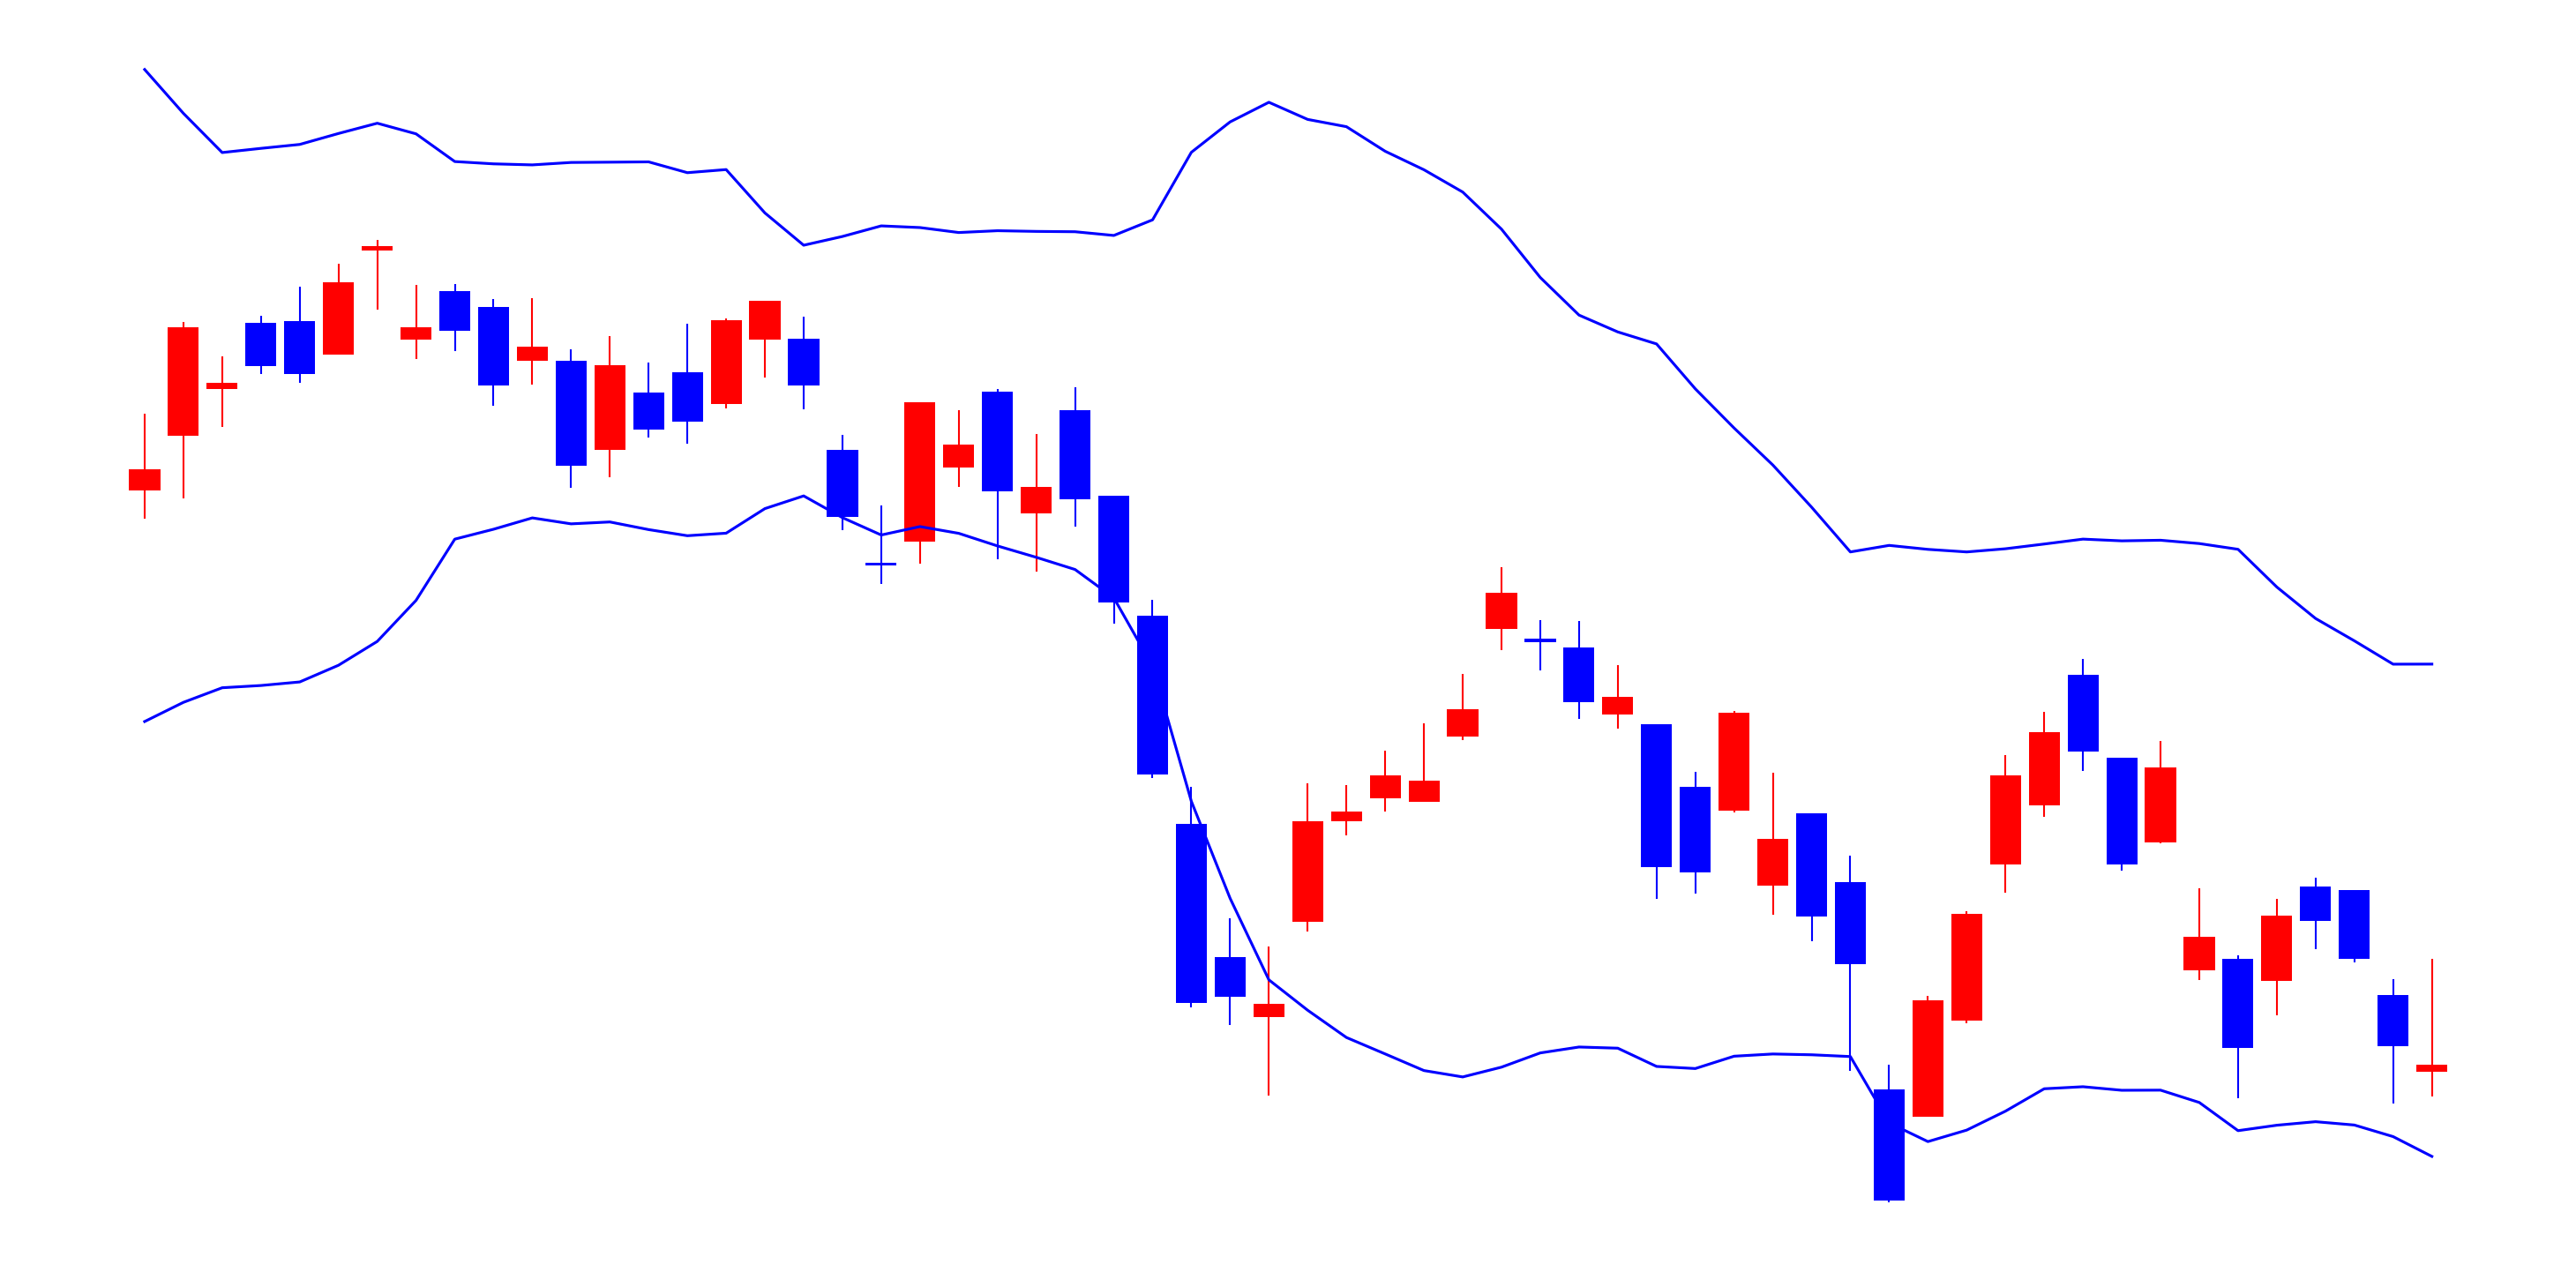

In [7]:
sample_df = df.iloc[-60:, :].reset_index(drop=True)
fig = plot_candles(sample_df, title=None, trend_line=False, volume_bars=False, color_function=None, technicals=[sample_df['BBAND_UPPER'], sample_df['BBAND_LOWER']])

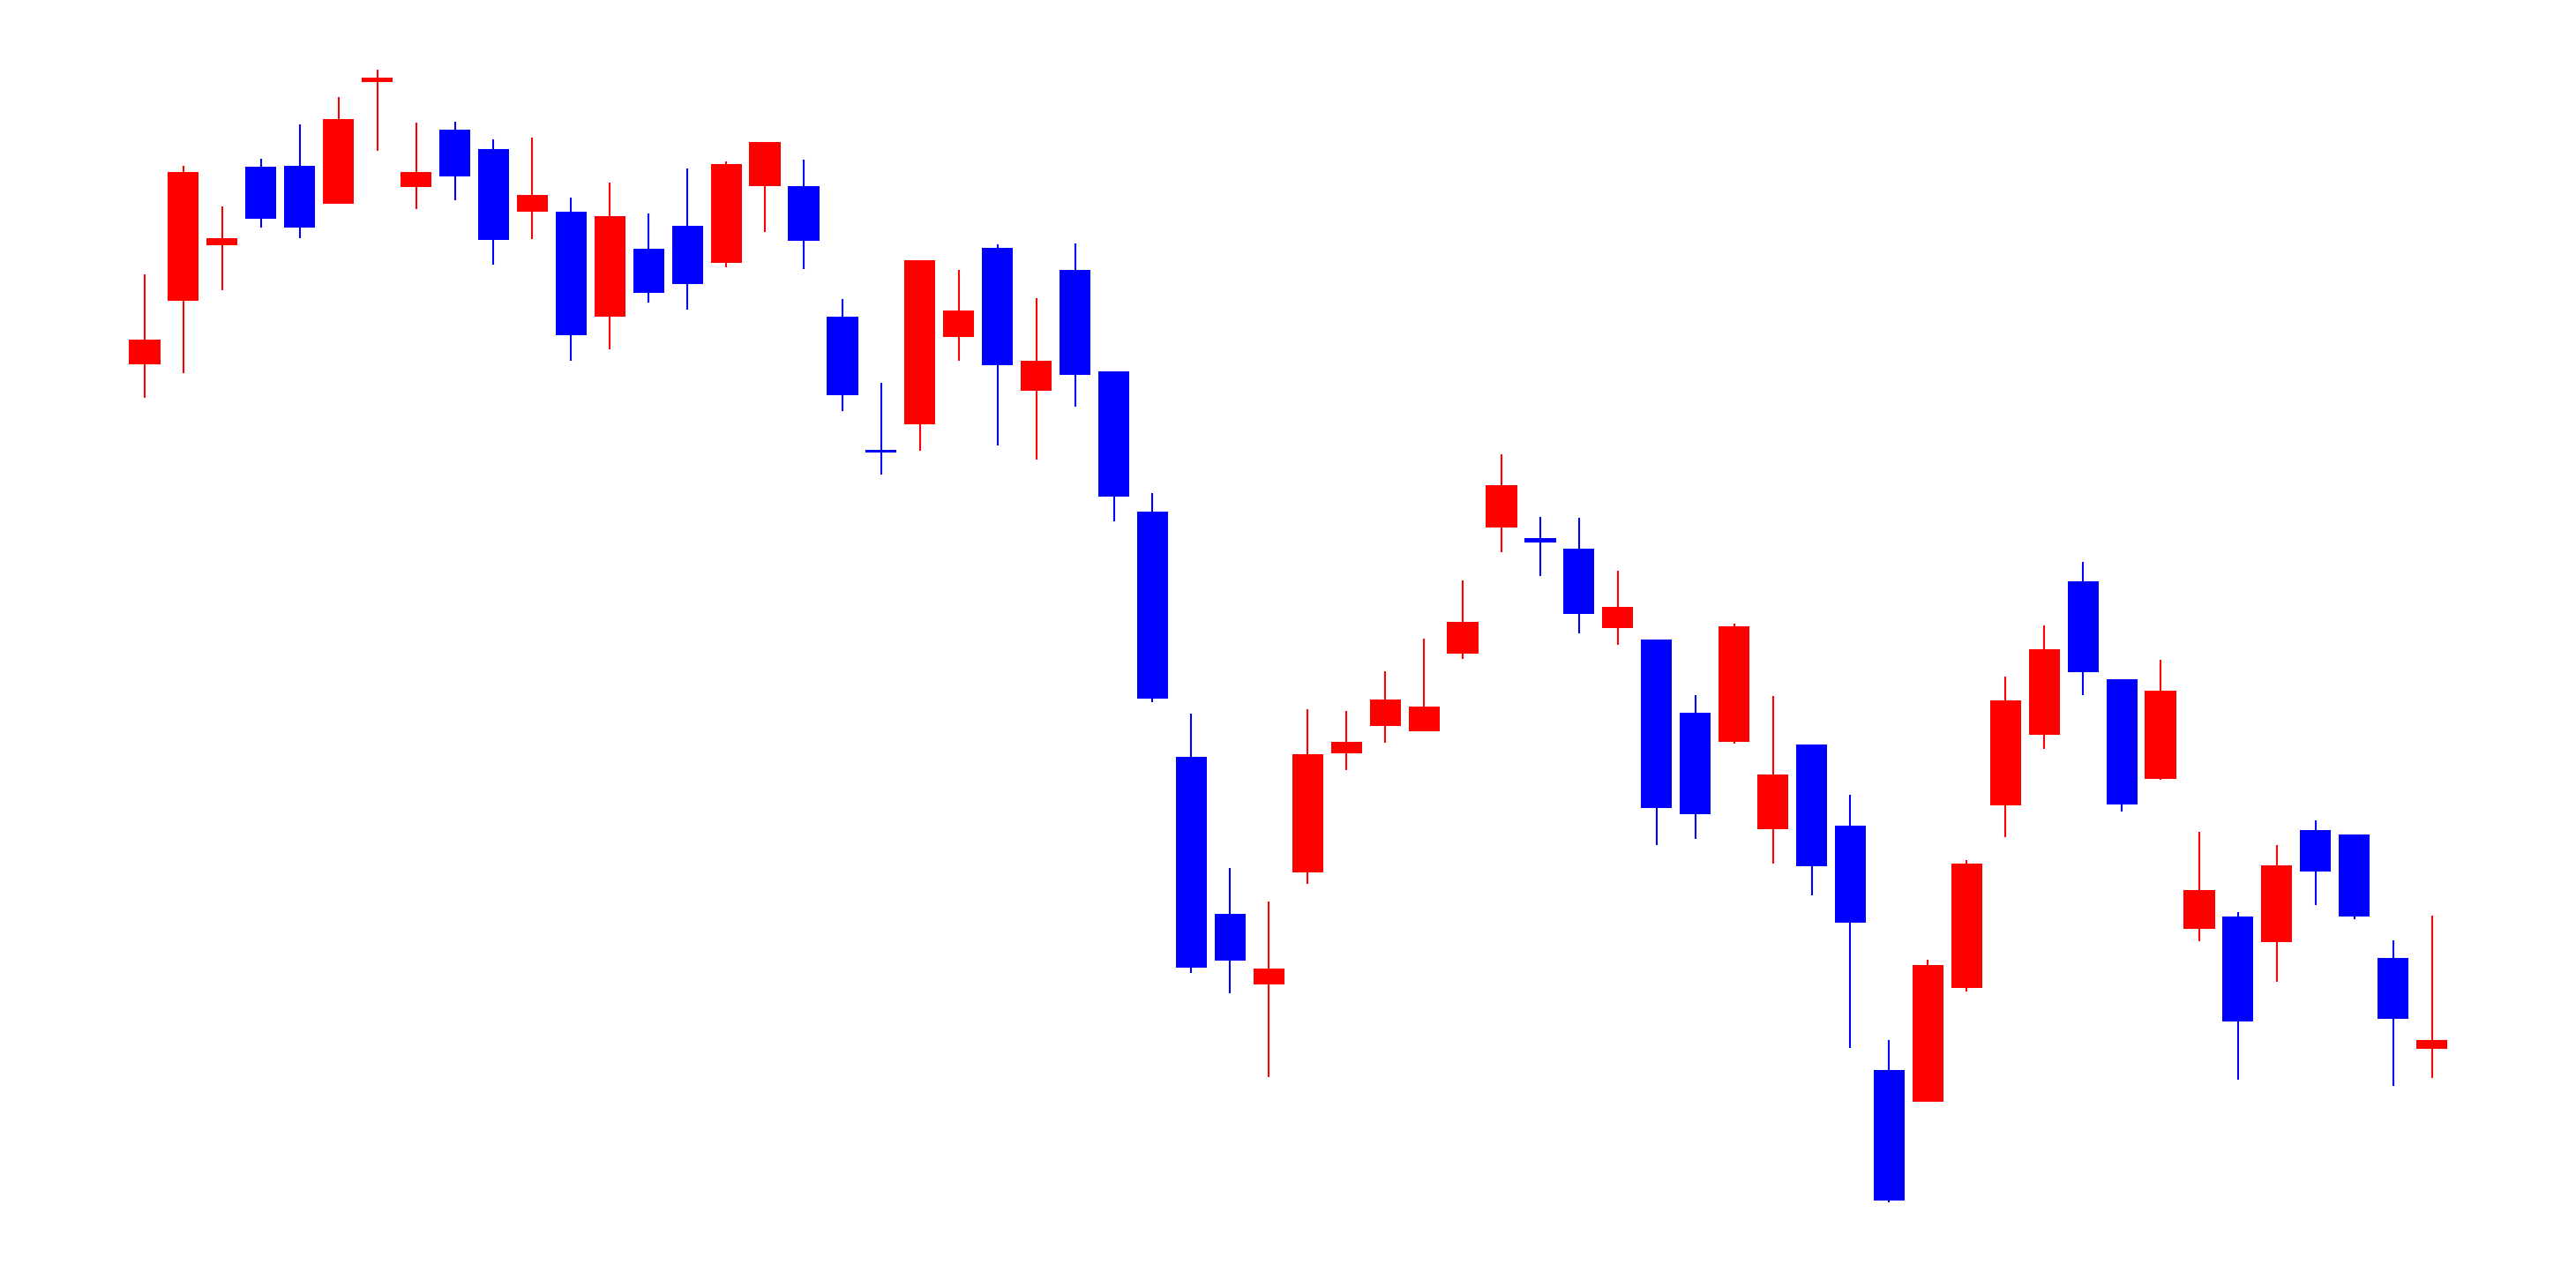

In [8]:
fig = plot_candles(sample_df, title=None, trend_line=False, volume_bars=False, color_function=None, technicals=None)

(-2.95, 61.95, 2357.717298146056, 2699.5935794161555)

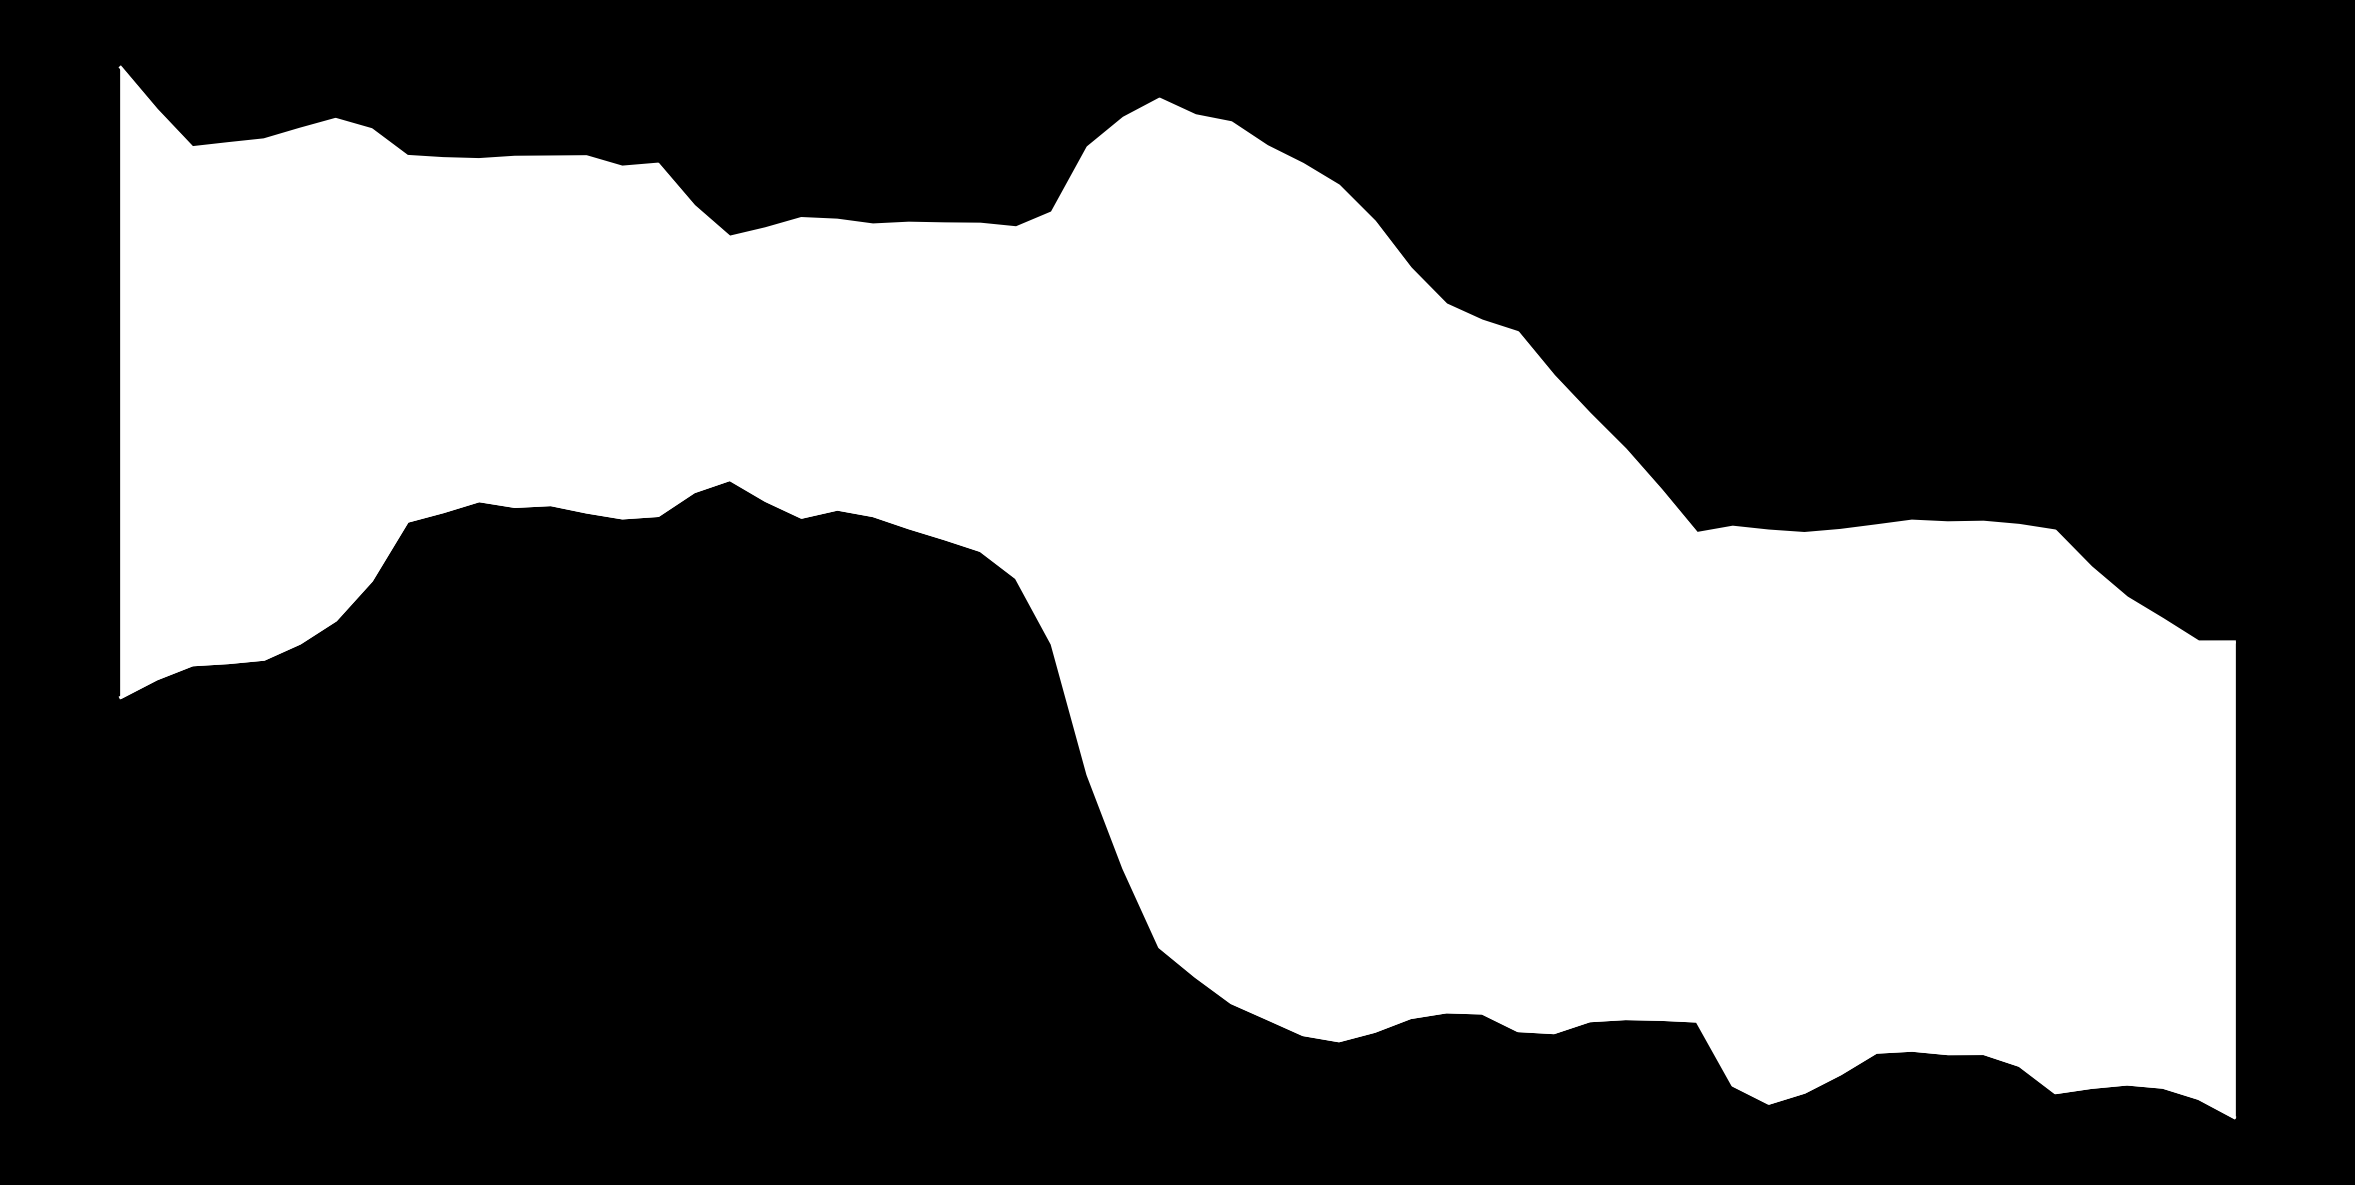

In [9]:
plt.figure(facecolor='black', figsize=(20,10))
plt.fill_between(sample_df.index, sample_df['BBAND_LOWER'], sample_df['BBAND_UPPER'], color='white')
plt.plot(sample_df['BBAND_UPPER'], label='Upper Bollinger Band', color='white')
# plt.plot(sample_df['BBAND_MIDDLE'], label='Middle Bollinger Band', color='white')
plt.plot(sample_df['BBAND_LOWER'], label='Lower Bollinger Band', color='white')
plt.axis('off')

In [16]:
df = pd.read_csv('./data/origin_data/stock_data.csv')
df.head()

,time,open,high,low,close,volume,BBAND_UPPER,BBAND_MIDDLE,BBAND_LOWER
0,2022-02-10 09:00:00,370.70,371.90,370.70,371.55,7202,NaN,NaN,NaN
1,2022-02-10 09:01:00,371.55,371.85,371.35,371.80,3007,NaN,NaN,NaN
2,2022-02-10 09:02:00,371.80,372.10,371.45,371.65,3332,NaN,NaN,NaN
3,2022-02-10 09:03:00,371.65,371.80,371.50,371.65,1575,NaN,NaN,NaN
4,2022-02-10 09:04:00,371.65,371.70,371.30,371.45,1585,NaN,NaN,NaN


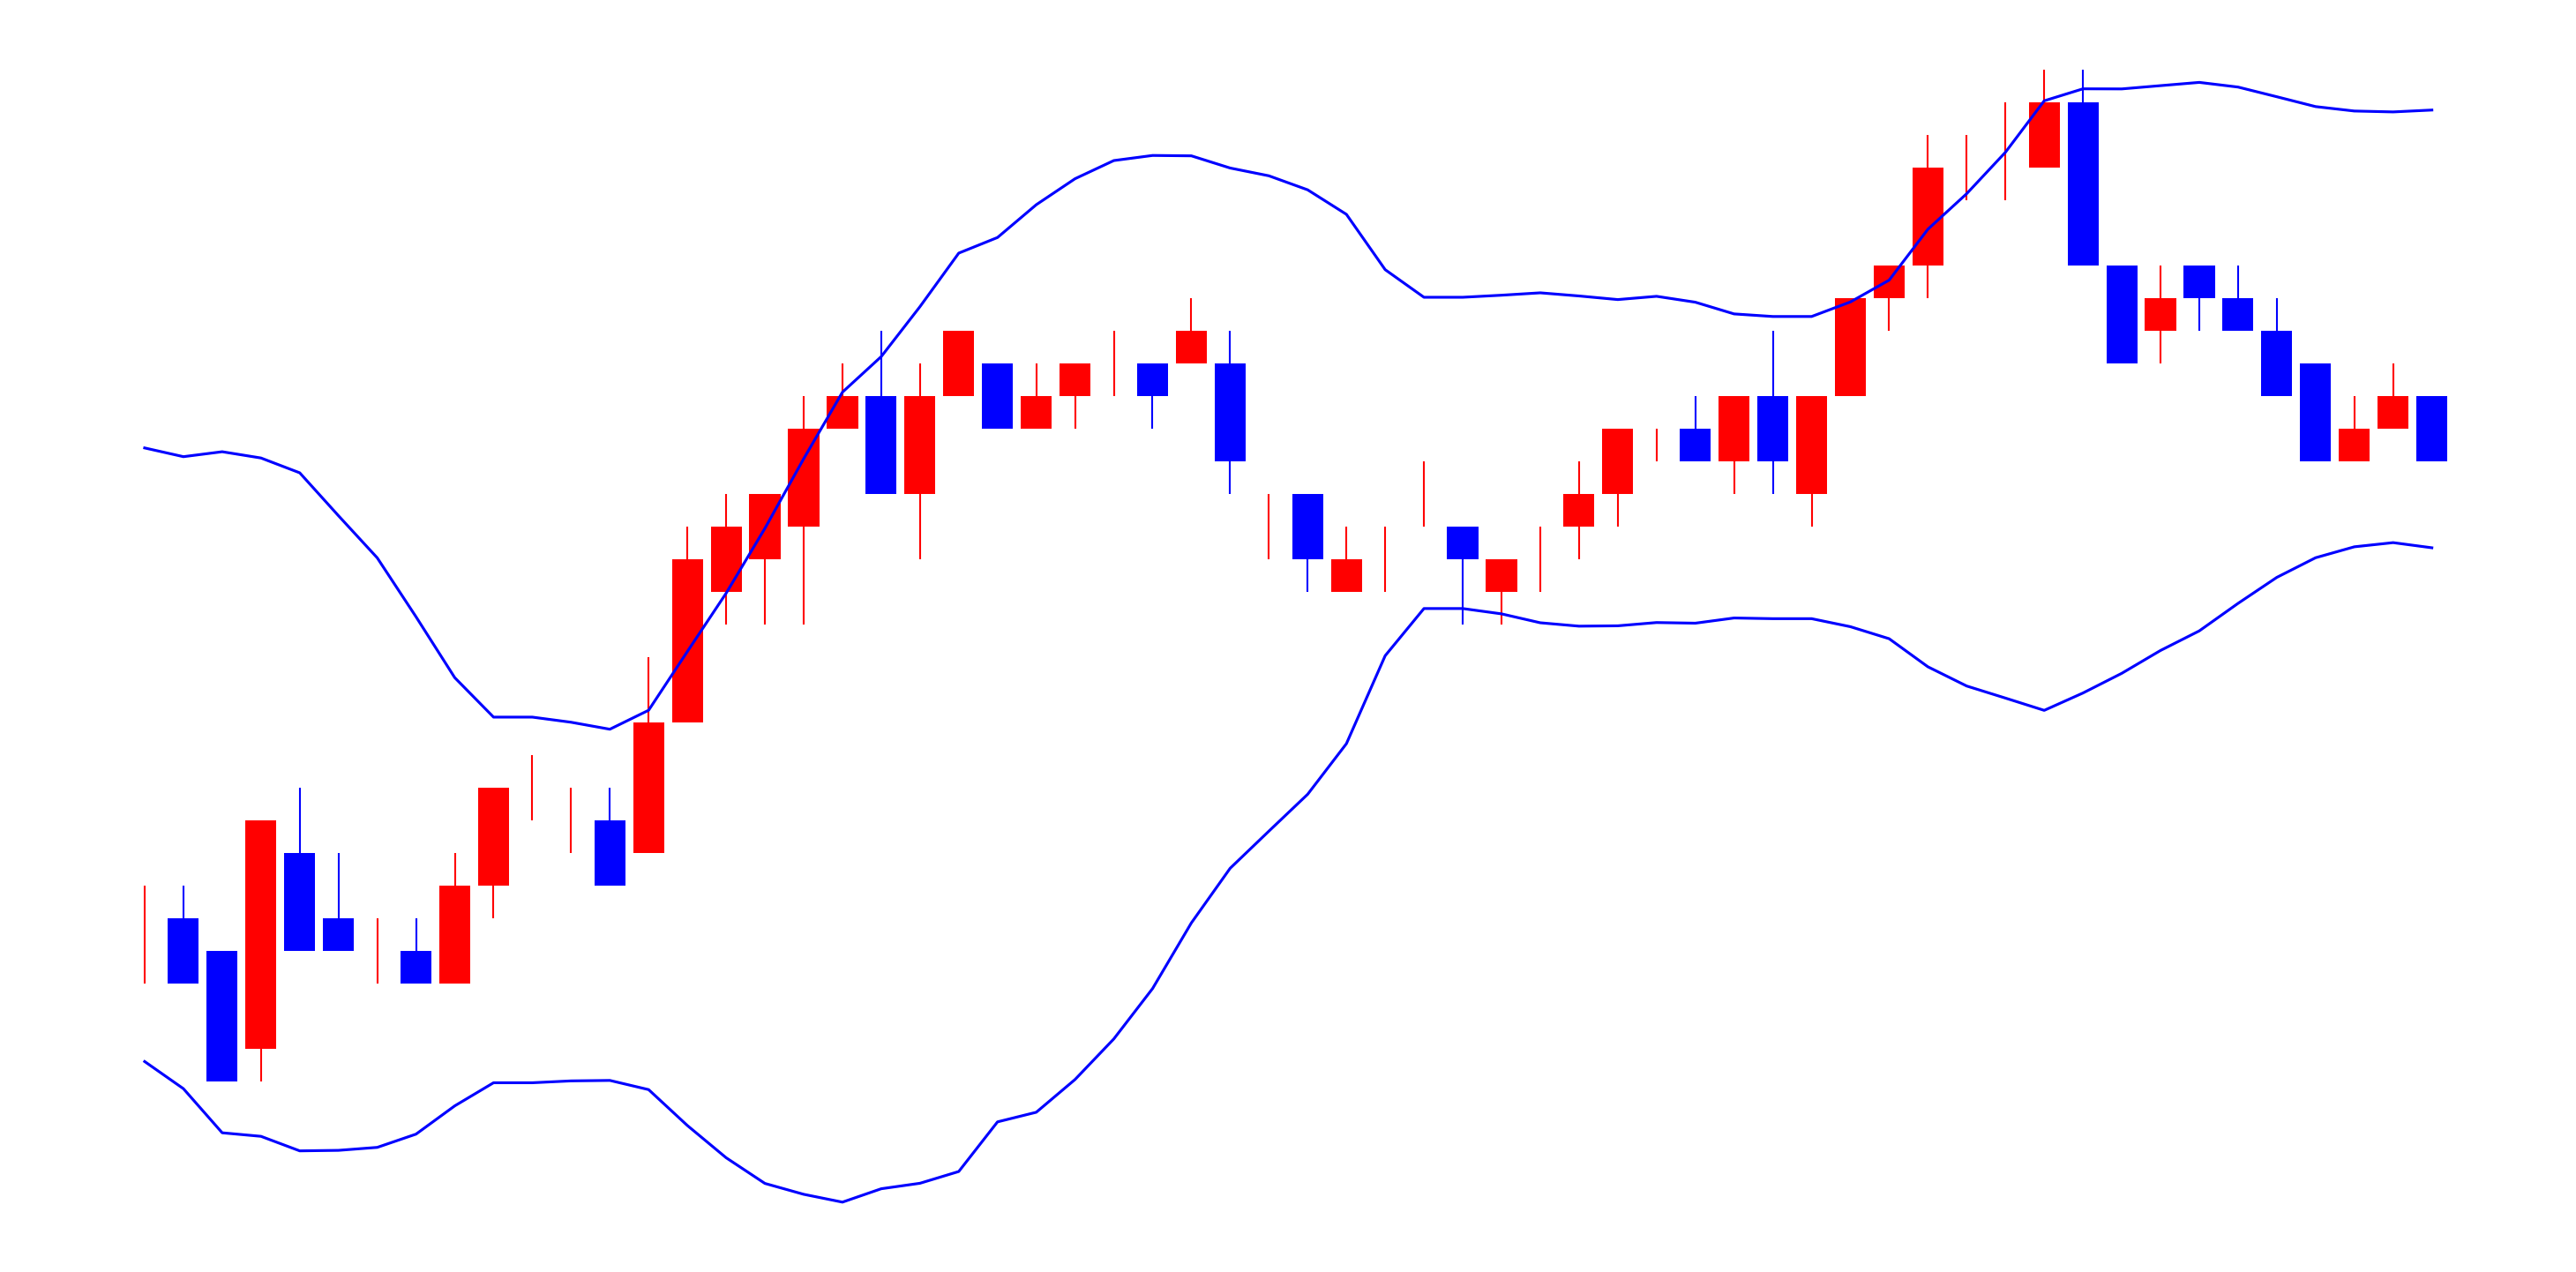

In [26]:
df['time'] = pd.to_datetime(df['time'])

filtered_df = df[df['time'].dt.date == pd.to_datetime('2024-03-12').date()].reset_index(drop=True)
filtered_df = filtered_df[5 *22 : 5 *22 +60].reset_index(drop=True)
fig = plot_candles(filtered_df, title=None, trend_line=False, volume_bars=False, color_function=None, technicals=[filtered_df['BBAND_UPPER'], filtered_df['BBAND_LOWER']])

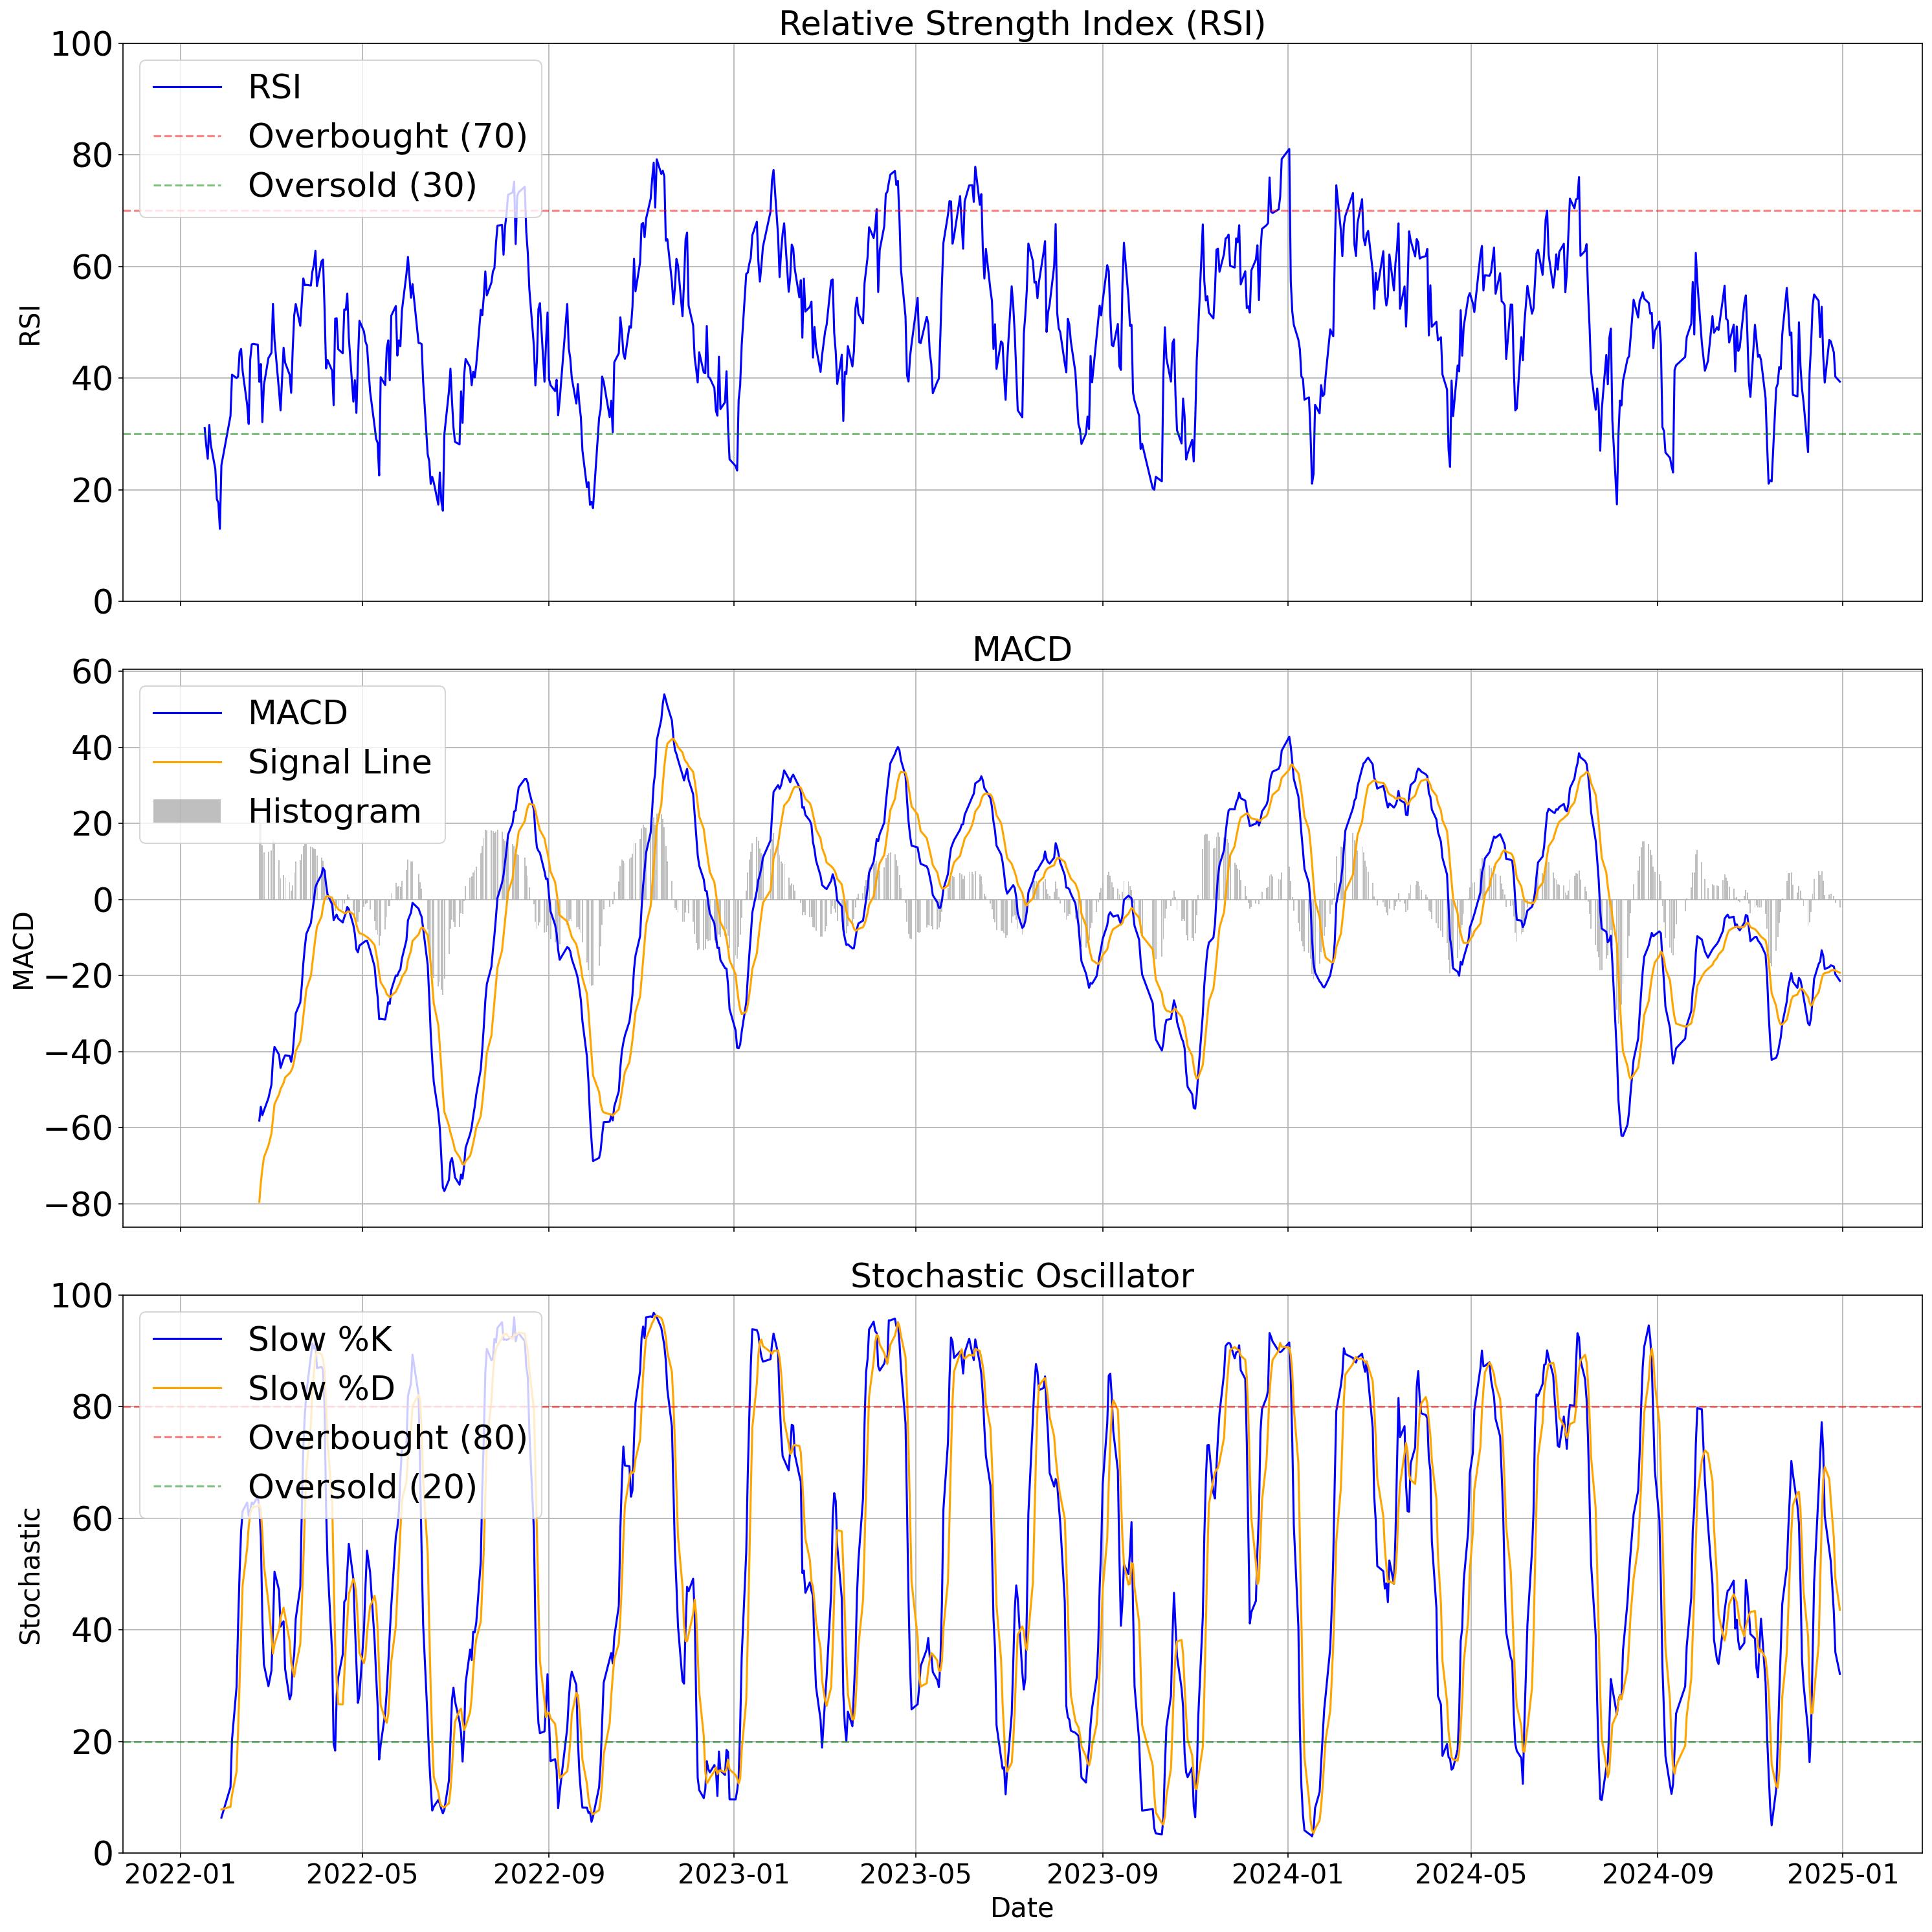

In [14]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.titlesize': 25,    # 제목 폰트 크기
    'axes.labelsize': 20,    # Y축 레이블 폰트 크기 (metric 강조)
    'xtick.labelsize': 20,   # X축 눈금 레이블 폰트 크기
    'ytick.labelsize': 25,   # Y축 눈금 레이블 폰트 크기
    'legend.fontsize': 25    # 범례 폰트 크기
})

# MACD 계산 (원래 코드에 없어서 추가)
df['MACD'], df['MACD_Signal'], _ = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# 3개의 서브플롯 생성
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

# 1. RSI
ax1.plot(df.index, df['RSI'], label='RSI', color='blue')
ax1.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax1.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax1.set_title('Relative Strength Index (RSI)')
ax1.set_ylabel('RSI')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.grid(True)

# 2. MACD
ax2.plot(df.index, df['MACD'], label='MACD', color='blue')
ax2.plot(df.index, df['MACD_Signal'], label='Signal Line', color='orange')
ax2.bar(df.index, df['MACD'] - df['MACD_Signal'], label='Histogram', color='gray', alpha=0.5)
ax2.set_title('MACD')
ax2.set_ylabel('MACD')
ax2.legend(loc='upper left')
ax2.grid(True)

# 3. Stochastic
ax3.plot(df.index, df['slowk'], label='Slow %K', color='blue')
ax3.plot(df.index, df['slowd'], label='Slow %D', color='orange')
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Overbought (80)')
ax3.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='Oversold (20)')
ax3.set_title('Stochastic Oscillator')
ax3.set_ylabel('Stochastic')
ax3.set_ylim(0, 100)
ax3.legend(loc='upper left')
ax3.grid(True)
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()